This notebook sets up a SFINCS model for the area of interest and the period of the flood event. In this example, the October 2023 storm surge in the area Fischland-Darss-Zingst in on the German Baltic Coast. 
1. Standard SFINCS model.
2. SFINCS model with added dikes
3. SFINCS model with dikes and breaches in dikes.   

#TO DO: Add wind (water level timeseries at observation point 2 does not match well yet, might miss wind set up)

In [1]:
from hydromt_sfincs import SfincsModel
from hydromt.config import configread
from hydromt.log import setuplog
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
import datetime
from hydromt_sfincs import utils
import xarray as xr
from shapely.geometry import Point
import requests, zipfile, io
from pathlib import Path



USER INPUT

Set the model directory.
Set start and end times 
Select the data sources. Here we use local data for bathymetry and topography, which are specified in the data.yml file. 
Water level forcings are received from a local tide gauge. Provide coordinates in the model's coordinate reference system and the download url.

In [2]:
# Model directory
# main_dir = Path(r"p:\11209308-floodadapt-trinidad\InterTwin")
main_dir = Path(r"c:\Users\winter_ga\Offline_data\projects\InterTwin")

model_dir = "model"
run_name = "model_20m_nowind"      

# Start and end times
tstart= "20231015 070000"
tstop= "20231023 000000"

# model resolution
res = 20

mask_file = main_dir.joinpath("Geodaten\mask_25833.geojson")

# water levels
wl_csv = main_dir.joinpath("Wasserstaende\pegelonline-barhft-W-20231015-20231023.csv")
# offset of tide gauge from local datum
waterlevel_offset = -498

# INitial water level
inifile = main_dir.joinpath("Geodaten\zsini_regridded_20m_final.tif")

logger = setuplog()
# opt = configread(os.path.join(main_dir,"fdz_base.yml"))

# Bathymetry and topography data in data.yml
data_libs=main_dir.joinpath("TopoBathy\data.yml")
datasets_dep = [{"elevtn": "MVtopo_masked", "zmin": 0.01},{"elevtn": "ELC_INSPIRE"},{"elevtn": "merit_hydro"}]

# Water level boundary point coordinates (Barhoeft)
x = [372368.1]
y = [6033653.6]

# wind url
wind_url = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/wind/historical/stundenwerte_FF_00298_19810101_20231231_hist.zip"
wind_dir = main_dir.joinpath("Wind")

# Observation points for model validation
d = {'Station': ["Barhoeft","Barth","Althagen"], 
     'geometry': [
         Point(371100.0, 6034300.0), 
         Point(352691.1, 6027443.5),
         Point(332296.2, 6027473.9),
         ]}

dike_file = main_dir.joinpath(r"Geodaten\\all_dikes.gpkg")

breach_locations = {'Location': ["1","2"], 
     'geometry': [
         Point(342608.0, 6030840.0), 
         Point(344915.1, 6031933.0),
         ]}


2025-05-20 16:09:33,545 - hydromt - log - INFO - HydroMT version: 0.10.1


Generate SFINCS model and set
- Timing
- Resolution
- Mask
- Depth
- Roughness
- Initial water level. This is important in this use case because some if the land is below zero. Hence we prepared an initial water level map with zero in the water bodies and -1 over land.

Slow when using the p-drive. Alternatively, copy all folders to local drive and change main_dir and data sources in TopoBathy/data.yml/

In [4]:
# Make model
sf = SfincsModel(data_libs=data_libs,root=os.path.join(main_dir,model_dir,run_name), mode='w+', logger=logger)

sf.setup_config(
    tref= tstart,
    tstart= tstart,
    tstop= tstop,
    dtout= 10400.0,
    dthisout= 600.0,
    dtmaxout= 259200.0,
    zsini=-1.0,
    tspinup=86400,
    
)
sf.setup_grid_from_region(
    region = {'geom': mask_file},
    res = res,
    rotated = False,
    crs = 25833,
)
# sf.setup_dep(**opt['setup_dep'])
# sf.setup_subgrid(**opt['setup_dep'])

# Add depth information to modelgrid based on these chosen datasets
dep = sf.setup_dep(datasets_dep=datasets_dep)

sf.setup_mask_active(
    include_mask= mask_file,
    zmax= -50.0
)
sf.setup_mask_bounds(
    btype="waterlevel",
    zmax= 0
)


# dep = sf.setup_subgrid(
#     datasets_dep=datasets_dep,
#     # manning_land=0.04,
#     # manning_sea=manning_sea, 
#     # rgh_lev_land=0.0,
#     write_dep_tif=True,
#     write_man_tif=True,
#     nr_subgrid_pixels=4,
#     )

# set up roughness 
sf.setup_manning_roughness(
    manning_land=0.04,
    manning_sea=0.02,
    rgh_lev_land=0,  # the minimum elevation of the land
)

# set initial water level to zero, except over land set it to -1
ini_ds = xr.open_dataset(inifile, engine="rasterio")
ini_ds["zsini"] = ini_ds["band_data"]
ini_ds = ini_ds.drop(["band_data"])
sf.set_states(data=ini_ds["zsini"])
sf.set_config("inifile","sfincs.ini")


2025-05-20 16:10:08,817 - hydromt - data_catalog - INFO - Parsing data catalog from c:\Users\winter_ga\Offline_data\projects\InterTwin\TopoBathy\data.yml
2025-05-20 16:10:08,833 - hydromt - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\winter_ga\Offline_data\projects\InterTwin\model\model_20m_nowind\gis.
2025-05-20 16:10:08,834 - hydromt - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.1.0).
2025-05-20 16:10:08,837 - hydromt - geodataframe - INFO - Reading  vector data from c:\Users\winter_ga\Offline_data\projects\InterTwin\Geodaten\mask_25833.geojson
2025-05-20 16:10:08,855 - hydromt - rasterdataset - INFO - Reading MVtopo_masked raster data from C:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\mv_masked_clipped.tif
2025-05-20 16:10:08,895 - hydromt - rasterdataset - INFO - Reading ELC_INSPIRE raster data from C:\Users\winter_ga\Offline_data\projects\InterTwin\FDZ_model\ELC_INSPIRE\Baltic_Sea_Bathy.tif
2025-05

# Download and add wind.

This is commented out as it made the waterlevel comparisons at the tide gauges worse. 


In [6]:

# # download and add wind
# response = requests.get(wind_url)
# z = zipfile.ZipFile(io.BytesIO(response.content))
# z.extractall(wind_dir)
df_wind = pd.read_csv(wind_dir.joinpath("produkt_ff_stunde_19810101_20231231_00298.txt"),delimiter=";")

time = []
for t in df_wind.MESS_DATUM:
    tt = str(t)
    time.append(pd.Timestamp(year=int(tt[0:4]),month=int(tt[4:6]),day=int(tt[6:8]),hour=int(tt[8:])))

df_wind["time"] = time
df_wind = df_wind.set_index("time").drop(["STATIONS_ID","MESS_DATUM","QN_3","eor"],axis=1).rename(columns={"   F":"mag","   D": "dir"})

sf.setup_wind_forcing(timeseries=df_wind)



Add boundary point and water level at the boundary

,geometry
1,POINT (372368.1 6033653.6)


,1
time,
2023-10-15 00:00:00,-0.04
2023-10-15 00:01:00,-0.04
2023-10-15 00:02:00,-0.05
2023-10-15 00:03:00,-0.05
2023-10-15 00:04:00,-0.06
...,...
2023-10-23 23:55:00,0.36
2023-10-23 23:56:00,0.36
2023-10-23 23:57:00,0.36


2025-05-20 16:12:13,266 - hydromt - model_api - WARNING - Replacing forcing: bzs


(<Figure size 600x600 with 3 Axes>,
 array([<Axes: title={'center': 'SFINCS wind forcing (wnd)'}, ylabel='wind\n[m/s]'>,
        <Axes: title={'center': 'SFINCS waterlevel forcing (bzs)'}, ylabel='waterlevel\n[m+ref]'>],
       dtype=object))

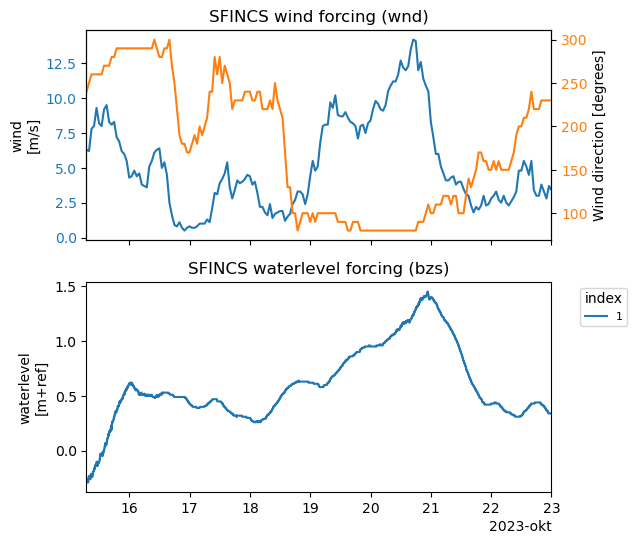

In [9]:
# set up water level boundary point (Barhoeft)
# add to Geopandas dataframe as needed by HydroMT
pnts = gpd.points_from_xy(x, y)
index = [1]  # NOTE that the index should start at one
bnd = gpd.GeoDataFrame(index=index, geometry=pnts, crs=sf.crs)

display(bnd)

# add waterlevel forcing
# we use measured timeseries
df = pd.read_csv(wl_csv, header=0,delimiter=";")
df=df.rename(columns={"timestamp":"time", "value":1})
df[1]=pd.to_numeric(df[1])

time = pd.to_datetime(df["time"])

# and the actual water levels, in this case for input location 1 a water level rising from 0 to 2 meters and back to 0:
bzs = ((df[1]+waterlevel_offset)/100).to_list()

bzspd = pd.DataFrame(index=time, columns=index, data=bzs)
display(bzspd)

# Actually add it to the SFINCS model class:
sf.setup_waterlevel_forcing(timeseries=bzspd, locations=bnd, buffer=1000)

# NOTE: the waterlevel forcing data is now stored in the sf.forcing dictionary
sf.forcing.keys()
sf.plot_forcing(fn_out="forcing.png")

Add observation points

In [ ]:
# setup observation points 
gdf = gpd.GeoDataFrame(d, crs="EPSG:25833")
display(gdf)

sf.setup_observation_points(
    locations=gdf, merge=False
)
    

In [ ]:
# Write results
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,model_dir,run_name,'basemap.png'))

Create model with dikes

In [ ]:
# Add dikes
# HydroMT function: get geodataframe from dike_file
gdf_floodwall = sf.data_catalog.get_geodataframe(
    dike_file, geom=sf.region, crs=sf.crs
)

# Add floodwall attributes to geodataframe
if (gdf_floodwall.geometry.type == "MultiLineString").any():
    gdf_floodwall = gdf_floodwall.explode()

# par1 is the overflow coefficient for weirs
gdf_floodwall["par1"] = 0.6

# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes"      

sf.set_root(root=os.path.join(main_dir,model_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,model_dir,run_name_dikes,'basemap.png'))


Remove line segments near breach from dike line features

In [ ]:
# find dike breaches
s = gpd.GeoSeries(gdf_floodwall.geometry)
breach_ids = s.sindex.nearest(breach_locations["geometry"])
gdf_floodwall_breached=gdf_floodwall.drop(index=breach_ids[1])

# par1 is the overflow coefficient for weirs
gdf_floodwall_breached["par1"] = 0.6

# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall_breached, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes_withbreaches"      

sf.set_root(root=os.path.join(main_dir,model_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,model_dir,run_name_dikes,'basemap.png'))


Alternative: not remove but lower dikes near breaches


In [ ]:
# find dike breaches
s = gpd.GeoSeries(gdf_floodwall.geometry)
breach_ids = s.sindex.nearest(breach_locations["geometry"])
gdf_floodwall_overtopped=gdf_floodwall.copy()

gdf_floodwall_overtopped["z"].loc[breach_ids[1]] = 1.0

# par1 is the overflow coefficient for weirs
gdf_floodwall_overtopped["par1"] = 0.6


# HydroMT function: create floodwall
sf.setup_structures(structures=gdf_floodwall_overtopped, stype="weir", merge=False)

run_name_dikes = run_name+"_dikes_overtopping_0-8"      

sf.set_root(root=os.path.join(main_dir,model_dir,run_name_dikes), mode="w+")
sf.write()
sf.plot_basemap()
plt.savefig(os.path.join(main_dir,model_dir,run_name_dikes,'basemap.png'))
